In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pylab as plt

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)
print(x_test.shape)

(550, 300)
(192, 300)


In [4]:
# It's a binary classification problem
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
seed = 100


def cross_validation(x_train, y_train, k=5):
    X = np.arange(len(x_train))
    np.random.seed(seed)
    np.random.shuffle(X)
    kfold_data = []

    tmp = len(X) % k
    s1 = 0
    idx_list = []

    for i in range(k):
        l = len(X) // k
        if i < tmp:
            l += 1
        s2 = s1 + l
        idx_list.append((s1, s2))
        s1 += l

    for s1, s2 in idx_list:
        indices = list(range(0, s1)) + list(range(s2, len(X)))
        kfold_data.append([X[indices], X[range(s1, s2)]])

    return kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10  # should contain 10 fold of data
# each element should contain train fold and validation fold
assert len(kfold_data[0]) == 2
# The number of data in each validation fold should equal to training data divieded by K
assert kfold_data[0][1].shape[0] == 55

In [7]:
print(kfold_data[0])

[array([ 98, 515, 348, 240, 241,  31,  72, 417, 470, 108, 412, 103, 489,
       518,  56, 173, 476, 502, 509,  97, 205,  78, 118, 288, 372,  37,
         6, 424,  58, 535, 290, 326, 249, 542, 512, 392, 125,  51, 219,
       133, 368, 410, 430, 272, 229, 120,  90, 494, 321, 191, 310,  62,
       235,  69, 454, 270, 453, 255, 421,  22,  41,  91, 352, 481, 260,
         1, 485, 190, 244, 136, 459,  43, 519, 455, 495, 140, 275,  23,
       189,  20, 152, 335, 163, 184, 100,   7, 337, 517,  18, 379, 514,
       328, 530, 442, 213, 523, 384, 510,  55, 287, 399, 416, 227,  61,
       330, 395, 282, 473, 268, 225, 471,  46,  50, 365, 169,  19, 159,
        35,  28, 216, 254, 312, 423, 154, 539,  96,  33, 239, 486, 129,
       456, 267,  21, 155, 544, 461, 487, 265, 124, 231, 451, 230, 533,
        75, 206, 203,  84, 393, 548, 126, 373, 443, 137, 297, 468,  64,
       367,   5, 450, 531, 315, 259, 127,  47, 505, 300, 209, 400, 411,
        80, 197, 338, 263, 174, 178,  88, 360,  45, 331, 524, 1

## example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=False)
kfold_data = []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" %
          (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], Validation index: [0 1 2 3]
Split: 2, Training index: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19], Validation index: [4 5 6 7]
Split: 3, Training index: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19], Validation index: [ 8  9 10 11]
Split: 4, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19], Validation index: [12 13 14 15]
Split: 5, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], Validation index: [16 17 18 19]


In [9]:
assert len(kfold_data) == 5  # should contain 5 fold of data
# each element should contains index of training fold and validation fold
assert len(kfold_data[0]) == 2
# The number of data in each validation fold should equal to training data divieded by K
assert kfold_data[0][1].shape[0] == 4

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [10]:
# your code
k = 5
kfold_data = cross_validation(x_train, y_train, k=k)
best_score, best_parameters = 0, dict(C=None, gamma=None)
c_param, gamma_param = [], []
score = []
for c_exp in range(-5, 6):
    c_param.append(10 ** c_exp)
for gamma_exp in range(-5, 6):
    gamma_param.append(10 ** gamma_exp)

for C in c_param:
    tmp = []

    for gamma in gamma_param:
        avg_val_score = 0

        for train_index, val_index in kfold_data:
            clf = SVC(C=C, kernel='rbf', gamma=gamma)
            clf.fit(x_train[train_index], y_train[train_index])
            y_pred = clf.predict(x_train[val_index])

            avg_val_score += accuracy_score(y_train[val_index], y_pred)

        avg_val_score /= k
        tmp.append(avg_val_score)

        print(f'C: {C}  gamma: {gamma} Val acc: {avg_val_score}')
        if avg_val_score > best_score:
            best_score = avg_val_score
            best_parameters = dict(C=C, gamma=gamma)

    score.append(tmp)

C: 1e-05  gamma: 1e-05 Val acc: 0.6890909090909091
C: 1e-05  gamma: 0.0001 Val acc: 0.6890909090909091
C: 1e-05  gamma: 0.001 Val acc: 0.6890909090909091
C: 1e-05  gamma: 0.01 Val acc: 0.6890909090909091
C: 1e-05  gamma: 0.1 Val acc: 0.6890909090909091
C: 1e-05  gamma: 1 Val acc: 0.6890909090909091
C: 1e-05  gamma: 10 Val acc: 0.6890909090909091
C: 1e-05  gamma: 100 Val acc: 0.6890909090909091
C: 1e-05  gamma: 1000 Val acc: 0.6890909090909091
C: 1e-05  gamma: 10000 Val acc: 0.6890909090909091
C: 1e-05  gamma: 100000 Val acc: 0.6890909090909091
C: 0.0001  gamma: 1e-05 Val acc: 0.6890909090909091
C: 0.0001  gamma: 0.0001 Val acc: 0.6890909090909091
C: 0.0001  gamma: 0.001 Val acc: 0.6890909090909091
C: 0.0001  gamma: 0.01 Val acc: 0.6890909090909091
C: 0.0001  gamma: 0.1 Val acc: 0.6890909090909091
C: 0.0001  gamma: 1 Val acc: 0.6890909090909091
C: 0.0001  gamma: 10 Val acc: 0.6890909090909091
C: 0.0001  gamma: 100 Val acc: 0.6890909090909091
C: 0.0001  gamma: 1000 Val acc: 0.68909090909

In [11]:
print(best_parameters)

{'C': 1000, 'gamma': 0.0001}


In [12]:
print(c_param)
print(gamma_param)
print(np.array(score).shape)

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
(11, 11)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

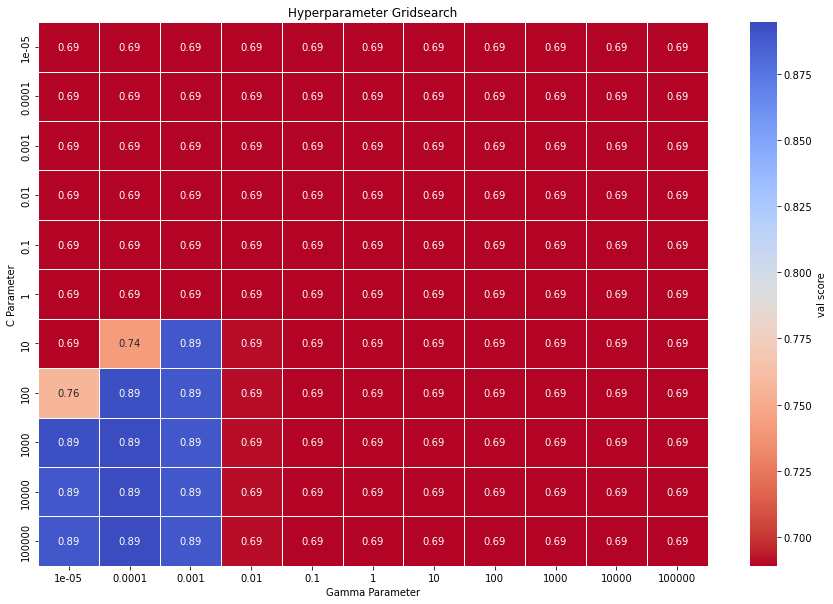

In [13]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(score,
                 annot=True,
                 xticklabels=gamma_param,
                 yticklabels=c_param,
                 linewidths=1.0,
                 cmap='coolwarm_r',
                 cbar_kws={'label': 'val score'})
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
plt.title("Hyperparameter Gridsearch")
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [14]:
C, gamma = 1000, 0.0001
best_model = SVC(C=C, kernel='rbf', gamma=gamma)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.90625
